<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch3_transformer_anatomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dig deeper into transofrmer theory

In [1]:
!pip install -qq transformers[sentencepiece] datasets bertviz

     |████████████████████████████████| 4.2 MB 8.7 MB/s 
     |████████████████████████████████| 342 kB 46.6 MB/s 
     |████████████████████████████████| 157 kB 42.6 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 212 kB 43.9 MB/s 
     |████████████████████████████████| 136 kB 71.2 MB/s 
     |████████████████████████████████| 127 kB 58.2 MB/s 
     |████████████████████████████████| 1.2 MB 52.2 MB/s 
     |████████████████████████████████| 132 kB 60.3 MB/s 
     |████████████████████████████████| 6.6 MB 41.2 MB/s 
     |████████████████████████████████| 596 kB 69.0 MB/s 
     |████████████████████████████████| 271 kB 59.8 MB/s 
     |████████████████████████████████| 144 kB 33.7 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 8.8 MB 41.0 MB/s 
ERROR: pip's dependen

In [2]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

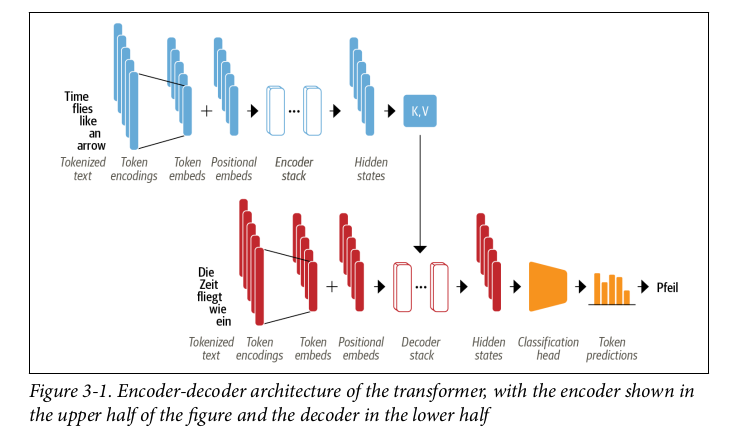

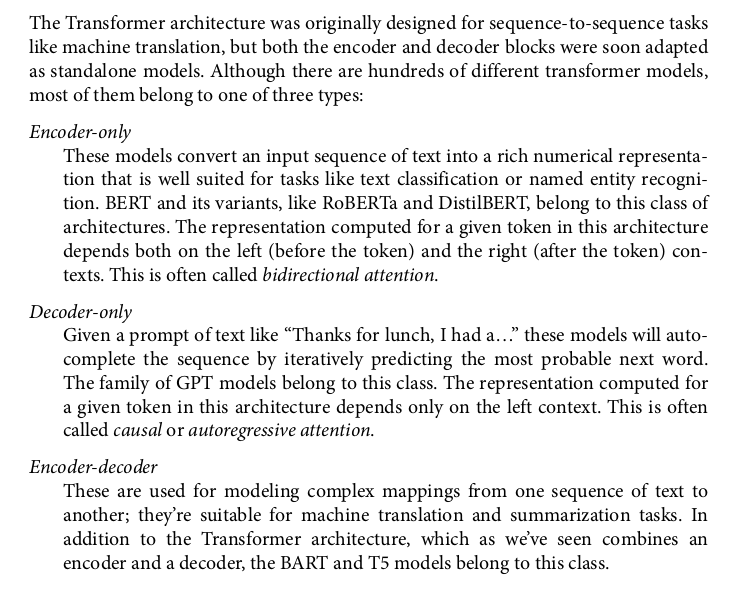

# The Encoder

Each encoder layer receives a sequence
of embeddings and feeds them through the following sublayers:
* A multi-head self-attention layer
* A fully connected feed-forward layer that is applied to each input embedding

The output embeddings of each encoder layer have the same size as the inputs.

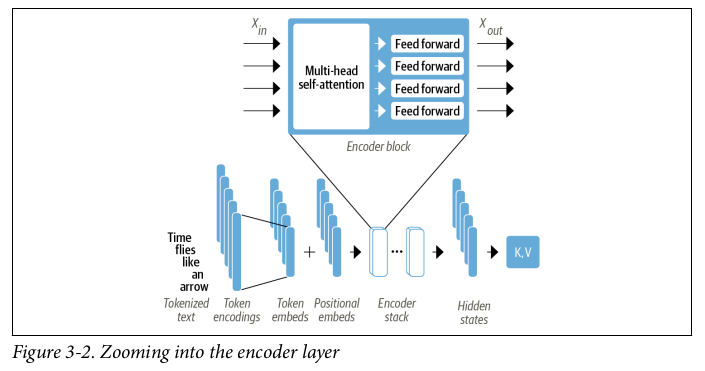

Let's start from the most important part - attention layer.

## Attention

### Main idea

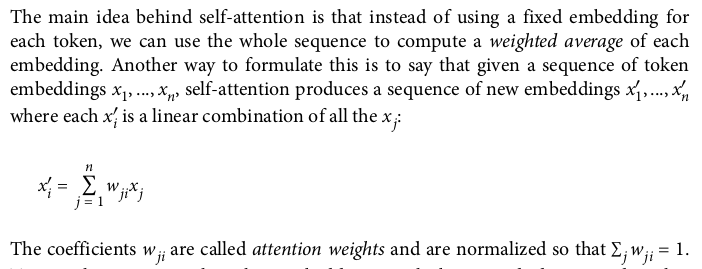

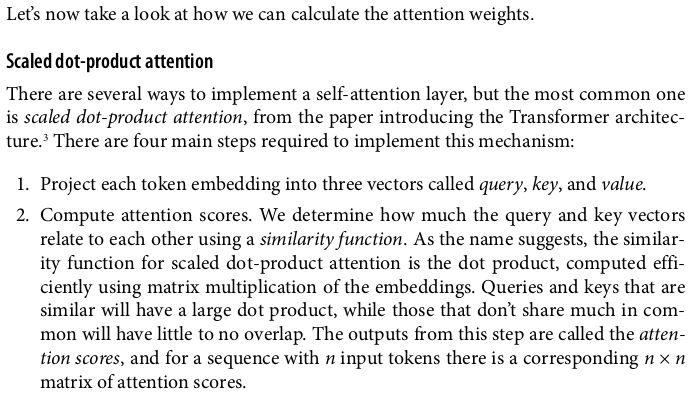

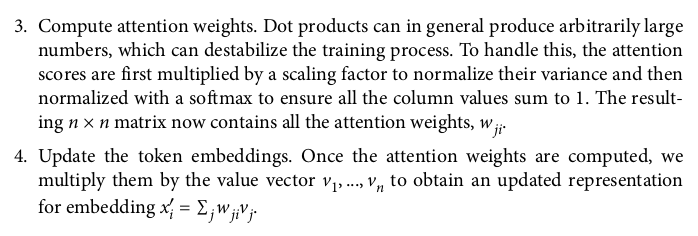

Attention layer visualization

In [3]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = 'times flies like an arrow'

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

100%|██████████| 440473133/440473133 [00:16<00:00, 27397482.99B/s]


In [4]:
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

More examples and details here: https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing

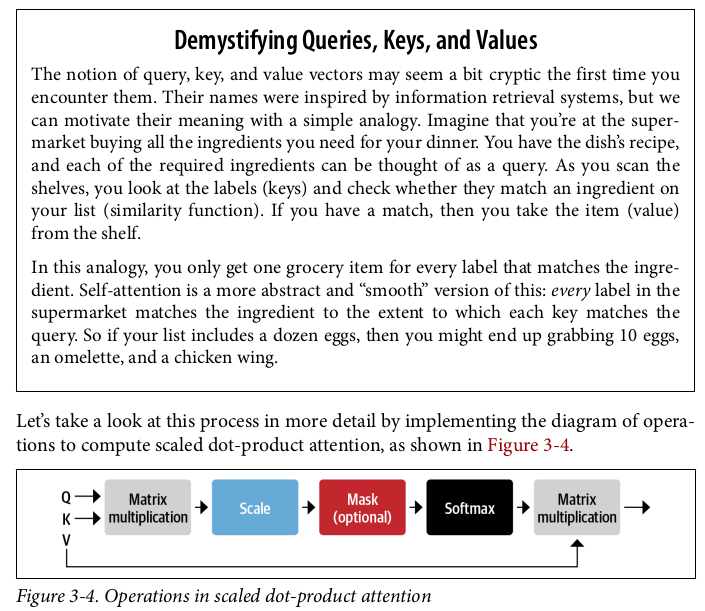

### Example of attention layer

In [5]:
text

'times flies like an arrow'

In [6]:
# Tokenize example text
inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False) #exclude CLS and SEP tokens for simplification
print(inputs)

{'input_ids': tensor([[ 2335, 10029,  2066,  2019,  8612]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}


In [7]:
from torch import nn 
from transformers import AutoConfig

In [8]:
# Create dense (without zeroes, not OHE) embeding
config = AutoConfig.from_pretrained(model_ckpt)

In [9]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [10]:
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)

In [11]:
token_emb

Embedding(30522, 768)

Note that the token embeddings at this point are independent of their context. This
means that homonyms (words that have the same spelling but different meaning),
like “flies” in the previous example, have the same representation. The role of the sub‐
sequent attention layers will be to mix these token embeddings to disambiguate and
inform the representation of each token with the content of its context.

Now we can caluclate embedings for out example tokens

In [12]:
inputs_embeds = token_emb(inputs.input_ids)

In [13]:
print(inputs_embeds.shape)
inputs_embeds

torch.Size([1, 5, 768])


tensor([[[ 0.9451, -0.8576,  1.2294,  ...,  1.2202, -1.2201,  0.4909],
         [ 0.3997, -0.8642, -1.7170,  ...,  1.7932,  1.2291, -0.9311],
         [-0.6890,  0.6104,  0.4568,  ..., -0.0894,  0.6328, -0.7167],
         [-0.2696,  0.2139,  0.6224,  ..., -0.4140, -0.7051, -0.1984],
         [-0.2624,  0.5430,  1.3556,  ..., -0.5635,  1.4605, -0.7314]]],
       grad_fn=<EmbeddingBackward0>)

1 batch, 5 vectors with length 768 each.

Ok, now we can find query, key and value for each vector

In [14]:
import torch
from math import sqrt

In [15]:
query = key = value = inputs_embeds
dim_k = key.size(-1)

In [16]:
dim_k

768

In [17]:
# Attention scores
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k) #find cosine distance between each vector
scores.size()

torch.Size([1, 5, 5])

In [18]:
scores

tensor([[[26.6128, -0.0953, -1.6053, -2.4419, -0.7736],
         [-0.0953, 28.8671, -0.2778, -1.8158,  0.8021],
         [-1.6053, -0.2778, 27.9880,  0.3133,  0.9751],
         [-2.4419, -1.8158,  0.3133, 25.2767,  0.3029],
         [-0.7736,  0.8021,  0.9751,  0.3029, 25.5255]]],
       grad_fn=<DivBackward0>)

In [19]:
# Apply softmax
import torch.nn.functional as F
weights = F.softmax(scores, dim=-1)

In [20]:
weights

tensor([[[1.0000e+00, 2.5168e-12, 5.5597e-13, 2.4083e-13, 1.2772e-12],
         [2.6411e-13, 1.0000e+00, 2.2004e-13, 4.7271e-14, 6.4793e-13],
         [1.4053e-13, 5.3001e-13, 1.0000e+00, 9.5723e-13, 1.8554e-12],
         [9.1617e-13, 1.7136e-12, 1.4406e-11, 1.0000e+00, 1.4257e-11],
         [3.7883e-12, 1.8314e-11, 2.1772e-11, 1.1116e-11, 1.0000e+00]]],
       grad_fn=<SoftmaxBackward0>)

In [21]:
# And find attention outputs
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In result:

In [22]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

Our attention mechanism with equal query and key vectors will assign a very large
score to identical words in the context, and in particular to the current word itself: the
dot product of a query with itself is always 1. But in practice, the meaning of a word
will be better informed by complementary words in the context than by identical
words—for example, the meaning of “flies” is better defined by incorporating infor‐
mation from “time” and “arrow” than by another mention of “flies”. 

How can we pro‐
mote this behavior?
Let’s allow the model to create a different set of vectors for the query, key, and value of
a token by using three different linear projections to project our initial token vector
into three different spaces.

### Multi headed attention

In example above attention approach was simplified. In practice, the self-attention
layer applies three independent linear transformations to each embedding to generate
the query, key, and value vectors.

It turns out to be beneficial to have multiple sets of linear projections, each one
representing a so-called attention head. The rea‐
son is that the softmax of one head tends to focus on mostly one aspect of similarity.
Having several heads allows the model to focus on several aspects at once.

Like in CNNs each convolution filter could focus on the particular image feature.

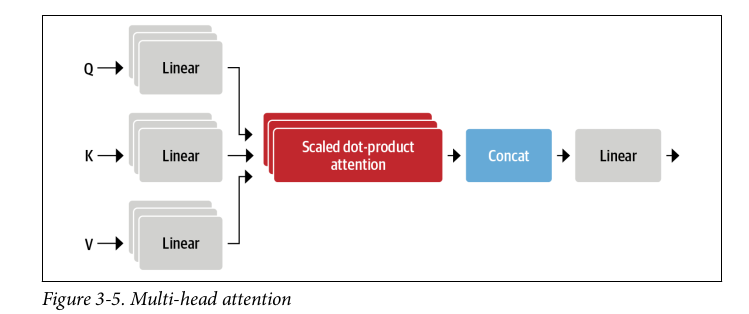

In [26]:
# Single attention head class
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state), 
                                                    self.k(hidden_state), 
                                                    self.v(hidden_state))
        return attn_outputs

In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

Check vector result size by using BERT configs

In [28]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

## The Feed-Forward Layer

The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully
connected neural network, but with a twist: instead of processing the whole sequence
of embeddings as a single vector, it processes each embedding independently. For this
reason, this layer is often referred to as a position-wise feed-forward layer.

In [29]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [30]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

## Adding Layer Normalization

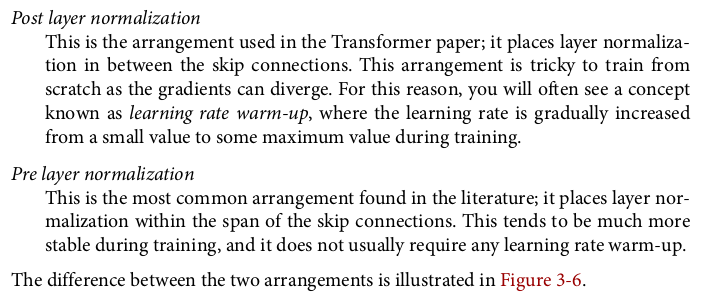

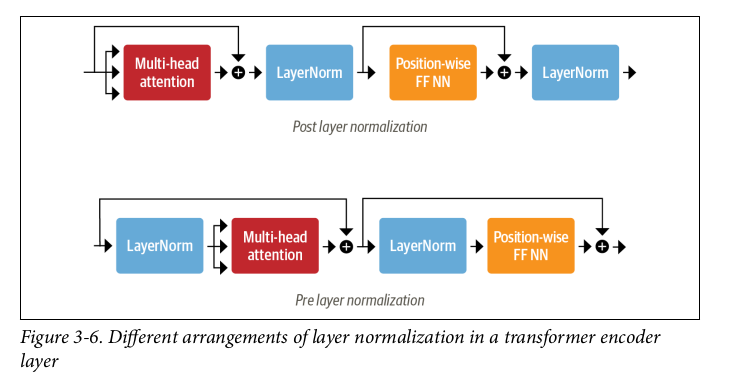

We’ll use the second arrangement

In [31]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [32]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

Currently layer invariant to the token positions. We need to add positional embedings.

## Positional embedings

Positional embeddings are based on a simple, yet very effective idea: augment the
token embeddings with a position-dependent pattern of values arranged in a vector.
If the pattern is characteristic for each position, the attention heads and feed-forward
layers in each stack can learn to incorporate positional information into their trans‐
formations.

Let’s create a custom Embeddings module that combines a token embedding layer that
projects the input_ids to a dense hidden state together with the positional embed‐
ding that does the same for position_ids . The resulting embedding is simply the
sum of both embeddings:

In [33]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
        config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
        config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [34]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

Let’s put all of this together now by building the full transformer encoder combining
the embeddings with the encoder layers:

In [36]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        
    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers: #pass embeding through several hidden layers
            x = layer(x)
        return x

In [37]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

## Classification head (optional)

In [38]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [39]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)

# The Decoder